Author: Nicolas Legrand <nicolas.legrand@cfin.au.dk>

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from systole.detection import oxi_peaks
from systole.plotting import plot_subspaces, plot_raw

sns.set_context('paper')
%matplotlib inline

# Heartbeat Counting task - Summary results

**Import data**

In [2]:
path = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)), 'data', 'raw', 'HBC')
subject = 'sub_0020'

In [3]:
resultsFiles = os.listdir(os.path.join(path, subject))

In [4]:
# Logs dataframe
df = pd.read_csv(os.path.join(path, subject, [file for file in resultsFiles if file.endswith('ratings.txt')][0]))
df

,nTrial,Reported,Condition,Duration,Confidence,ConfidenceRT
0,0,29,Count,45,3,8.616
1,1,26,Count,40,4,3.026
2,2,17,Count,30,3,4.714
3,3,16,Count,25,5,6.358
4,4,32,Count,50,2,1.625
5,5,36,Count,35,5,4.897


In [5]:
# PPG signal
ppg = {}
for i in range(6):
    ppg[str(i)] = np.load(os.path.join(path, subject, f'trial_{i}.npy'))

# Heartbeats and artefacts detection

This section reports the raw PPG signal together with the peaks detected. The instantaneous heart rate frequency (R-R intervals) is derived and represented below each PPG time series. Artefacts in the RR time series are detected using the method described in:

Lipponen, J. A., & Tarvainen, M. P. (2019). A robust algorithm for heart rate variability time series artefact correction using novel beat classification. Journal of Medical Engineering & Technology, 43(3), 173–181. https://doi.org/10.1080/03091902.2019.1640306

The shaded areas represent the pre-recording and post-recording period. Heartbeat detected inside these intervals are automatically removed.

## Loop across trials

Analyzing trial number 1


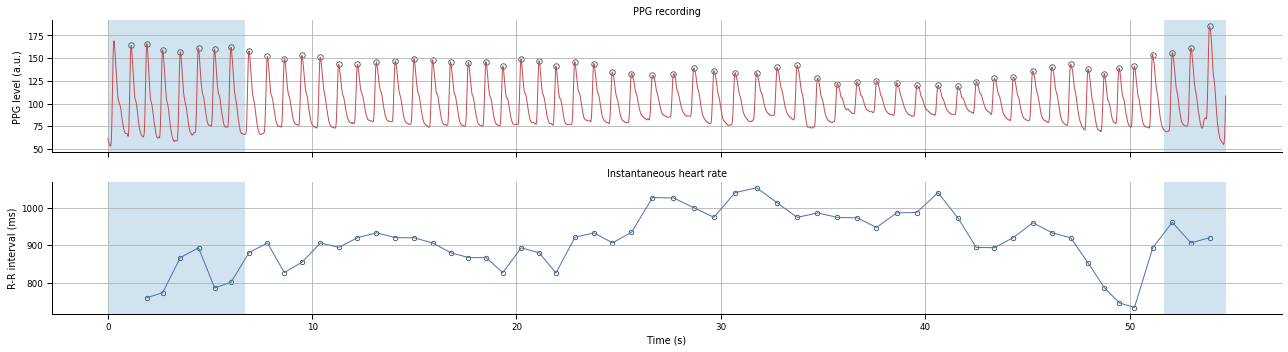

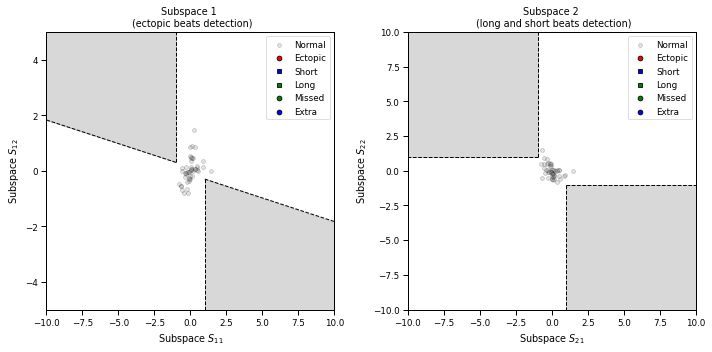

Reported: 29 beats ; Detected : 50 beats
Analyzing trial number 2


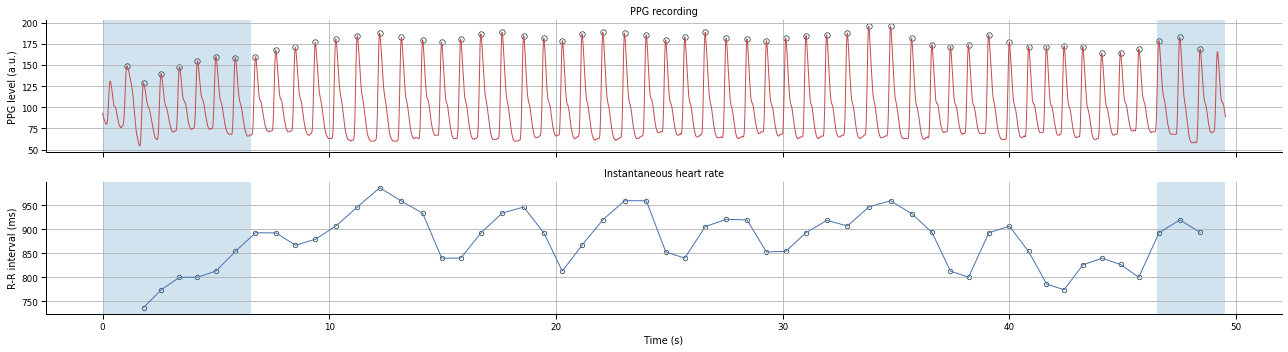

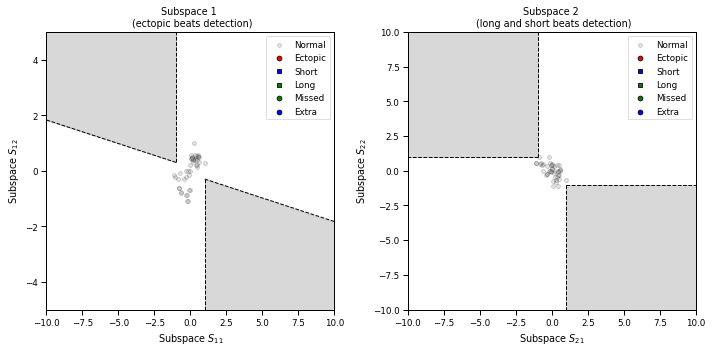

Reported: 26 beats ; Detected : 45 beats
Analyzing trial number 3


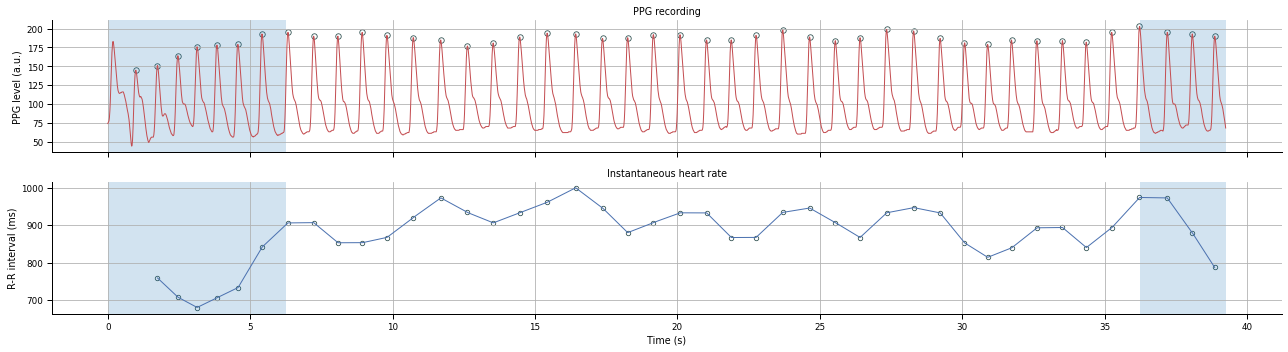

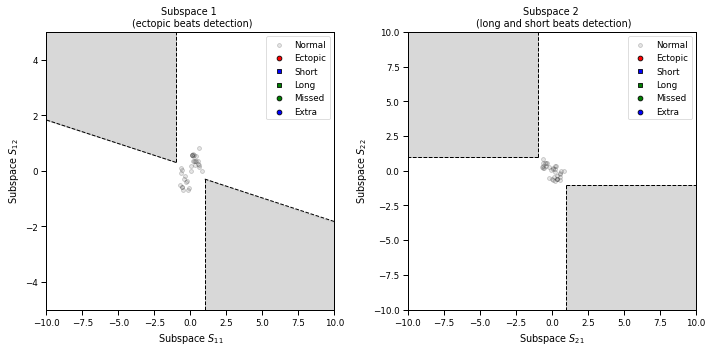

Reported: 17 beats ; Detected : 34 beats
Analyzing trial number 4


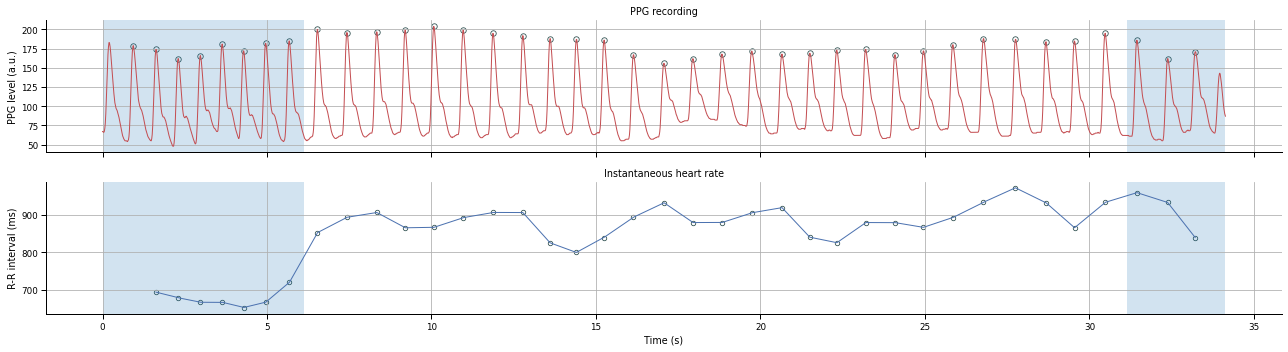

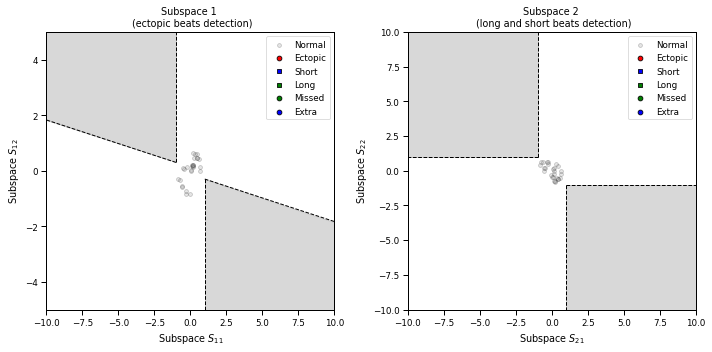

Reported: 16 beats ; Detected : 28 beats
Analyzing trial number 5


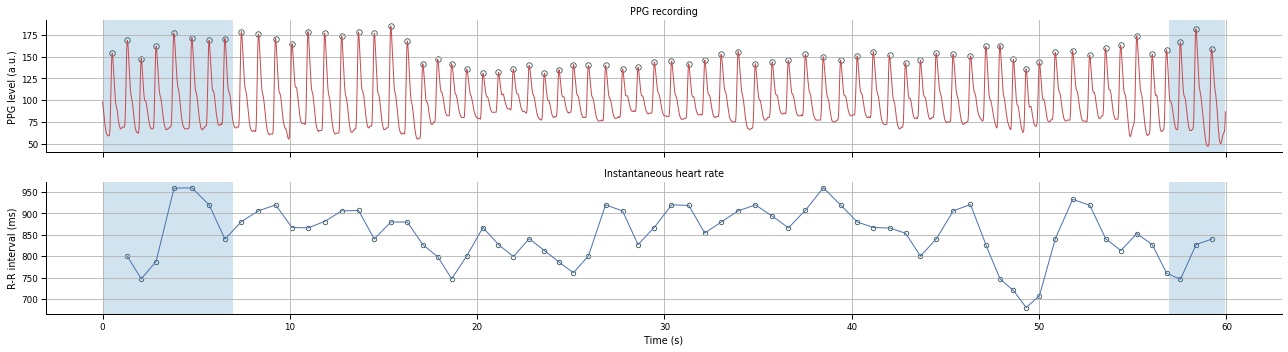

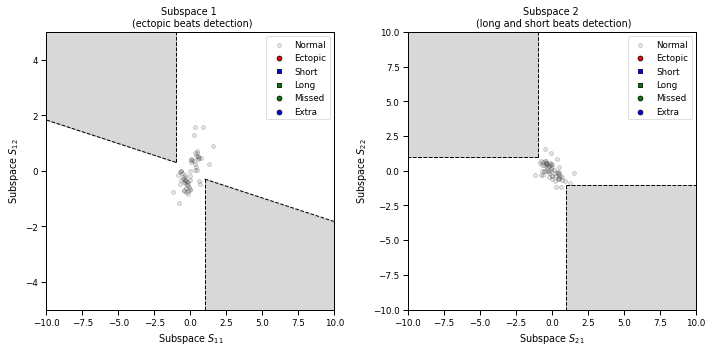

Reported: 32 beats ; Detected : 60 beats
Analyzing trial number 6


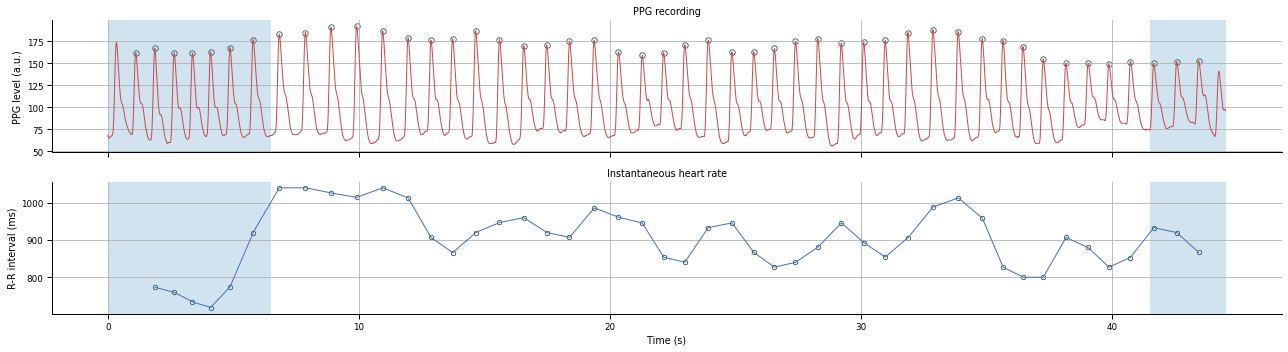

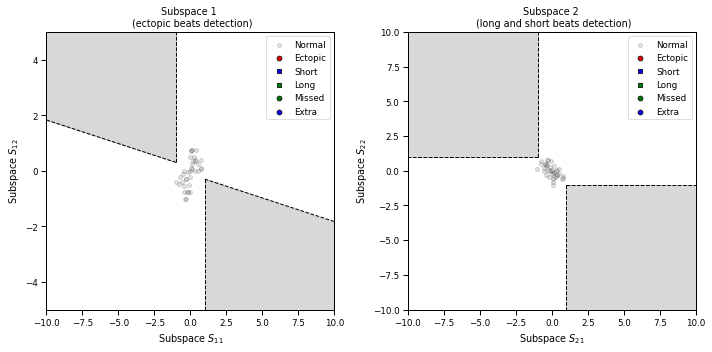

Reported: 36 beats ; Detected : 38 beats


In [6]:
counts = []
for nTrial in range(6):

    print(f'Analyzing trial number {nTrial+1}')

    signal, peaks = oxi_peaks(ppg[str(nTrial)], clean_extra=True)
    axs = plot_raw(signal, sfreq=1000, figsize=(18, 5), clean_extra=True);

    # Show window of interest
    l = len(signal)/1000
    for i in range(2):
        axs[i].axvspan(0, l - (3+df.Duration.iloc[nTrial]), alpha=.2)
        axs[i].axvspan(l-3, l, alpha=.2)
    plt.show()

    # Detected heartbeat in the time window of interest
    peaks = peaks[int(l - (3+df.Duration.iloc[nTrial]))*1000:int((l-3)*1000)]

    rr = np.diff(np.where(peaks)[0])
    plot_subspaces(rr=rr);
    plt.show()

    trial_counts = np.sum(peaks)
    print(f'Reported: {df.Reported.loc[nTrial]} beats ; Detected : {trial_counts} beats')
    counts.append(trial_counts)

## Save reulsts

In [7]:
# Add heartbeat counts and compute accuracy score
df['Counts'] = counts
df['Score'] = 1 - ((df.Counts - df.Reported).abs() / ((df.Counts + df.Reported)/2))

In [8]:
df

,nTrial,Reported,Condition,Duration,Confidence,ConfidenceRT,Counts,Score
0,0,29,Count,45,3,8.616,50,0.468354
1,1,26,Count,40,4,3.026,45,0.464789
2,2,17,Count,30,3,4.714,34,0.333333
3,3,16,Count,25,5,6.358,28,0.454545
4,4,32,Count,50,2,1.625,60,0.391304
5,5,36,Count,35,5,4.897,38,0.945946


In [9]:
df.to_csv(os.path.join(path, subject, 'processed.txt'))